<a href="https://colab.research.google.com/github/Isafon/ECE528/blob/main/ECE528_ASN5_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving iot-util.csv to iot-util.csv


In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM,SimpleRNN, Activation,Dropout
import numpy as np
from keras.optimizers import Adam
from keras.layers import Bidirectional
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [91]:
epochs = 10
batch_size = 32

In [100]:
# Each training data point will be length 100-1,
# since the last value in each sequence is the label
sequence_length = 100

In [113]:
def generate_model():
    from keras.models import Sequential
    from keras.layers import LSTM, Dense, Dropout

    model = Sequential()

    # --- Stronger temporal encoder ---
    model.add(LSTM(256, activation='tanh', return_sequences=True, input_shape=(sequence_length - 1, 1)))
    model.add(Dropout(0.2))

    # --- Bottleneck (forces compression of normal patterns) ---
    model.add(LSTM(128, activation='tanh', return_sequences=False))
    model.add(Dropout(0.2))

    # --- Nonlinear reconstruction layers ---
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))  # predict next point

    model.compile(optimizer='adam', loss='mse')
    return model

In [114]:
def normalize(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean

In [115]:
def prepare_data(data, train_start, train_end, test_start, test_end):
    print("Length of Data", len(data))

    # training data
    print("Creating training data...")

    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    result, result_mean = normalize(result)

    print("Training data shape  : ", result.shape)

    train = result[train_start:train_end, :]
    np.random.shuffle(train)
    X_train = train[:, :-1]
    y_train = train[:, -1]

    # test data
    print("Creating test data...")

    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    result, result_mean = normalize(result)

    print("Test data shape  : {}".format(result.shape))

    X_test = result[:, :-1]
    y_test = result[:, -1]

    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test

In [116]:
def run(model=None, data=None):
    global_start_time = time.time()

    print('Loading data... ')
    data_b = pd.read_csv('iot-util.csv',
                         parse_dates=[0], infer_datetime_format=True)
    data = data_b['cpu'].to_numpy()

    # train on first 500 samples and test on last 160 samples (test set has anomaly)
    X_train, y_train, X_test, y_test = prepare_data(data, 0, 600, 400, 660)

    if model is None:
        model = generate_model()

    try:
        print("Training...")
        model.fit(
                X_train, y_train,
                batch_size=batch_size, epochs=epochs, validation_split=0.05)
        print("Predicting...")
        predicted = model.predict(X_test, verbose=1)
        print("Reshaping predicted")
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        print("prediction exception")
        print('Training duration:{}'.format(time.time() - global_start_time))
        return model, y_test, 0

    try:
        rmse_series = np.sqrt((y_test - predicted) ** 2)
        plt.figure(figsize=(20,8))
        plt.plot(y_test[:len(y_test)], 'b', label='Observed')
        plt.plot(predicted[:len(y_test)], 'g', label='Predicted')
        plt.plot(rmse_series, 'r', label='RMSE (per time step)')
        plt.legend()
        plt.show()
    except Exception as e:
        print("plotting exception")
        print(str(e))
    print('Training duration:{}'.format(time.time() - global_start_time))

    return model, y_test, predicted

Loading data... 
Length of Data 660
Creating training data...
Training data shape  :  (500, 100)
Creating test data...
Test data shape  : (160, 100)
Shape X_train (500, 99)
Shape X_test (160, 99)
Training...
Epoch 1/10


/tmp/ipython-input-1696365755.py:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data_b = pd.read_csv('iot-util.csv',
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 425ms/step - loss: 0.4958 - val_loss: 0.1208
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 373ms/step - loss: 0.1805 - val_loss: 0.0963
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 413ms/step - loss: 0.1608 - val_loss: 0.1015
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 418ms/step - loss: 0.1359 - val_loss: 0.0886
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 369ms/step - loss: 0.1311 - val_loss: 0.0997
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 415ms/step - loss: 0.1362 - val_loss: 0.0876
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 373ms/step - loss: 0.1605 - val_loss: 0.0785
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 416ms/step - loss: 0.1155 - val_loss: 0.0614
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 370ms/step - loss: 0.0913 - val_loss: 0.0509
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 387ms/step - loss: 0.1093 - val_loss: 0.0542
Predicting...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
Reshaping predicted


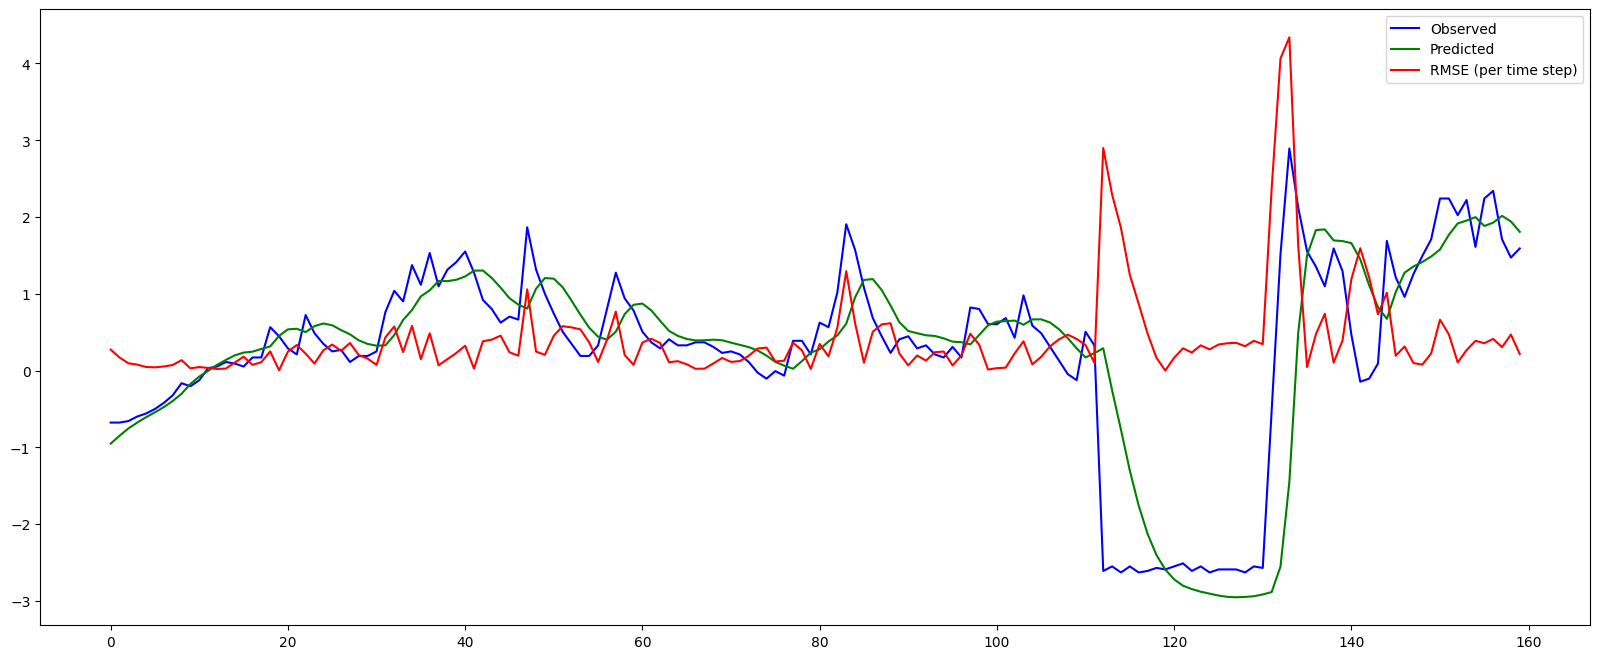

Training duration:71.78793978691101


In [117]:
model, y_test, predicted = run()

In [118]:
start_time = 0
rmse_series = np.sqrt((y_test - predicted) ** 2)

mean_rmse = np.mean(rmse_series)
std_rmse  = np.std(rmse_series)
# Anomaly threshold = Mean RMSE + 2 * Std RMSE is chosen based on empirical analyses
threshold = mean_rmse + 1.8 * std_rmse

print(f"Mean RMSE: {mean_rmse:.3f}")
print(f"Standard Deviation of RMSE: {std_rmse:.3f}")
print(f"Anomaly Threshold: {threshold:.3f}\n")

# Detect anomalies (indices where RMSE > threshold)
anomaly_indices = np.where(rmse_series > threshold)[0]

if len(anomaly_indices) > 0:
    print("Detected anomalies (index, RMSE):")
    for idx in anomaly_indices:
        print(f"Anomaly at time {start_time + idx} | RMSE value: {rmse_series[idx]:.3f}")

# Calculate RMSE(normal), RMSE(anomaly), and SNR

if len(anomaly_indices) > 0:
    rmse_anomaly = rmse_series[anomaly_indices]
    rmse_normal = rmse_series[rmse_series <= threshold]

    mean_rmse_normal = np.mean(rmse_normal)
    mean_rmse_anomaly = np.mean(rmse_anomaly)
    snr = mean_rmse_anomaly / mean_rmse_normal

    print("\n--- Model Evaluation Metrics ---")
    print(f"RMSE (Normal points): {mean_rmse_normal:.3f}")
    print(f"RMSE (Anomaly points): {mean_rmse_anomaly:.3f}")
    print(f"Signal-to-Noise Ratio (SNR): {snr:.2f}")

Mean RMSE: 0.415
Standard Deviation of RMSE: 0.607
Anomaly Threshold: 1.508

Detected anomalies (index, RMSE):
Anomaly at time 112 | RMSE value: 2.899
Anomaly at time 113 | RMSE value: 2.292
Anomaly at time 114 | RMSE value: 1.859
Anomaly at time 131 | RMSE value: 2.365
Anomaly at time 132 | RMSE value: 4.064
Anomaly at time 133 | RMSE value: 4.341
Anomaly at time 134 | RMSE value: 1.630
Anomaly at time 141 | RMSE value: 1.594

--- Model Evaluation Metrics ---
RMSE (Normal points): 0.298
RMSE (Anomaly points): 2.631
Signal-to-Noise Ratio (SNR): 8.82
